In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np

pd.set_option('display.max_columns', 500)

df = pd.read_pickle('data/candlestick_15m_ETHBTC_2107021313.pkl')
df.set_index('open_time', inplace=True)
df.sort_index(inplace=True)
df.tail()

,pair_id,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,created_at,updated_at
open_time,,,,,,,,,,,,,
2021-07-02 03:00:00,0,0.062944,0.063175,0.062896,0.063087,1210.511,2021-07-02 03:14:59,76.283867,1829,715.191,45.064299,2021-07-02 03:00:12.340782+00:00,2021-07-02 03:15:33.157623+00:00
2021-07-02 03:15:00,0,0.063087,0.063201,0.062751,0.062783,1650.940,2021-07-02 03:29:59,104.022572,2608,746.156,47.023885,2021-07-02 03:15:33.157623+00:00,2021-07-02 03:30:21.555569+00:00
2021-07-02 03:30:00,0,0.062785,0.062785,0.062267,0.062326,2269.186,2021-07-02 03:44:59,141.858378,4303,1050.212,65.659002,2021-07-02 03:30:21.555569+00:00,2021-07-02 03:45:21.613905+00:00
2021-07-02 03:45:00,0,0.062334,0.062367,0.061986,0.062038,2196.710,2021-07-02 03:59:59,136.456879,3911,1281.412,79.591470,2021-07-02 03:45:21.613905+00:00,2021-07-02 04:00:21.599261+00:00
2021-07-02 04:00:00,0,0.062028,0.062098,0.061952,0.062070,1109.910,NaT,68.858576,1528,499.305,30.978440,2021-07-02 04:00:21.599261+00:00,2021-07-02 04:10:21.669405+00:00


In [2]:
def add_lookback_trades(df, levels=1, cols=['open','high','low','close']):
    '''
    Adds [cols] columns for previous records to each row. New columns are
    suffixed with the record backstep. For example: open_1 means the open
    price 1 record back.
    '''
    new_df = df.copy()
    for l in range(1,levels+1):
        new_cols={c:f'{c}_{l}' for c in cols}
        new_df = new_df.merge(df[cols].shift(l).bfill().rename(columns=new_cols),
                              how='left', left_index=True, right_index=True)
    return new_df

def add_lookforward_trades(df, levels=1, cols=['open','high','low','close']):
    '''
    Adds [cols] columns for future records to each row. New columns are
    suffixed with the record forwardstep. For example: open_1 means the open
    price 1 record forward.
    '''
    new_df = df.copy()
    for l in range(1,levels+1):
        new_cols={c:f'{c}_{l}' for c in cols}
        new_df = new_df.merge(df[cols].shift(-l).ffill().rename(columns=new_cols),
                              how='left', left_index=True, right_index=True)
    return new_df

def calculate_ma(df, period=14, field='close'):
    '''
    Calculate Moving Average
    '''
    df2=df[[field]].copy()
    return df2.rolling(period, min_periods=1).mean()

def calculate_atr(df, period=14):
    '''
    Calculate the Average True Range (ATR)
    '''
    df2=df[['high','low','close']].copy()
    df2=add_lookback_trades(df2,1,['high','low','close'])
    #df2['tr_calc'] = np.max([df2.high-df2.low, np.abs(df2.high-df2.close_1), np.abs(df2.low-df2.close_1)], axis=0)
    df2['tr_calc'] = np.max([df2.high, df2.close_1], axis=0) - np.min([df2.low, df2.close_1], axis=0)
    return df2.tr_calc.rolling(period, min_periods=1).mean()

def calculate_rsi(df, period=14, field='close'):
    '''
    Calculate Relative Stength Indicator (RSI)
    Source: https://www.learnpythonwithrune.org/pandas-calculate-the-relative-strength-index-rsi-on-a-stock/
    '''
    df2=df[[field]].copy()
    delta = df2.close.diff()
    up = delta.clip(lower=0)
    down = -1*delta.clip(upper=0)
    ema_up = up.ewm(com=period-1, adjust=False).mean()
    ema_down = down.ewm(com=period-1, adjust=False).mean()
    rs = ema_up/ema_down
    rs[0] = 0 # backfill with 0
    return 100 - (100/(1 + rs))

def calculate_upward_trend(df, period):
    '''
    Calculates if trend is going up based on moving average being
    negative or positive
    '''
    trend = calculate_ma(df, period).diff()
    return np.where(trend.close.to_numpy()>0,True,False)

def cs_shooting_star(x):
    '''
    Source: https://en.wikipedia.org/wiki/Shooting_star_(candlestick_pattern)
    '''
    if x.open > x.close: return False
    s=x.high-x.low
    t=x.low+s*0.382  # Fibonacci Ratio - Retracement Level
    if t>=x.close: return True
    else: return False

def cs_shooting_star_R(x):
    '''
    Source: https://en.wikipedia.org/wiki/Shooting_star_(candlestick_pattern)
    '''
    if x.open <= x.close: return False
    s=x.high-x.low
    t=x.low+s*0.382  # Fibonacci Ratio - Retracement Level
    if t>=x.open: return True
    else: return False

def cs_hammer(x):
    '''
    Source: https://en.wikipedia.org/wiki/Hammer_(candlestick_pattern)
    '''
    if x.open < x.close: return False
    s=x.high-x.low
    t=x.high-s*0.382  # Fibonacci Ratio - Retracement Level
    if t<=x.close: return True
    else: return False
    
def cs_hammer_R(x):
    '''
    Source: https://en.wikipedia.org/wiki/Hammer_(candlestick_pattern)
    '''
    if x.open >= x.close: return False
    s=x.high-x.low
    t=x.high-s*0.382  # Fibonacci Ratio - Retracement Level
    if t<=x.open: return True
    else: return False
    
def cs_bearish_harami(x, complete=False):
    '''
    The body of the right candle stick must fit inside
    the body of the left candle stick.
    Source: https://www.investopedia.com/terms/b/bearishharami.asp
    '''
    if x.open > x.close and \
       x.open_1 < x.close_1 and \
       x.close_1 >= x.open and x.open_1 <= x.close and \
       x.high_1 >= x.high and x.low_1 <= x.low:
        return True
    else:
        return False

def cs_bullish_harami(x):
    '''
    The body of the right candle stick must fit inside
    the body of the left candle stick.
    Source: https://www.investopedia.com/terms/b/bullishharami.asp
    '''
    if x.open < x.close and \
       x.open_1 > x.close_1 and \
       x.close_1 <= x.open and x.open_1 >= x.close and \
       x.high_1 >= x.high and x.low_1 <= x.low:
        return True
    else:
        return False

def cs_engulfing_bullish(x):
    '''
    The body of the left candle stick must fit inside
    the body of the right candle stick.
    Source: https://animasmarketing.com/candlesticks-different-types/
    '''
    if x.open < x.close and \
       x.open_1 > x.close_1 and \
       x.close_1 >= x.open and x.open_1 <= x.close and \
       x.high_1 <= x.high and x.low_1 >= x.low:
        return True
    else:
        return False
    
def cs_engulfing_bearish(x):
    '''
    The body of the left candle stick must fit inside
    the body of the right candle stick.
    Source: https://animasmarketing.com/candlesticks-different-types/
    '''
    if x.open > x.close and \
       x.open_1 < x.close_1 and \
       x.close_1 <= x.open and x.open_1 >= x.close and \
       x.high_1 <= x.high and x.low_1 >= x.low:
        return True
    else:
        return False

In [3]:
def add_features(df, skip_lookback=False):
    df2 = df.copy()
    
    # this adds the past 3 records of price of data to each row
    if not skip_lookback:
        df2 = add_lookback_trades(df2, 3)
    
    df2['ma14'] = calculate_ma(df2)
    df2['ma30'] = calculate_ma(df2,30)
    df2['ma90'] = calculate_ma(df2,90)
    
    df2['atr'] = calculate_atr(df2)
    df2['atr_diff'] = df2.atr.diff().fillna(0)
    df2['atr_ma14'] = calculate_ma(df2, field='atr')
    df2['rsi'] = calculate_rsi(df2)
    df2['rsi_diff'] = df2.rsi.diff().fillna(0)
    df2['rsi_ma14'] = calculate_ma(df2, field='rsi')
    
    # The below are booleans
    df2['trend_up'] = calculate_upward_trend(df2,1)
    df2['trend_up3'] = calculate_upward_trend(df2,3)
    df2['trend_up14'] = calculate_upward_trend(df2,14)
    df2['trend_up30'] = calculate_upward_trend(df2,30)

    df2['cs_ss'] = df2.apply(cs_shooting_star, axis=1)
    df2['cs_ssR'] = df2.apply(cs_shooting_star_R, axis=1)
    df2['cs_hm'] = df2.apply(cs_hammer, axis=1)
    df2['cs_hmR'] = df2.apply(cs_hammer_R, axis=1)

    df2['cs_brh'] = df2.apply(cs_bearish_harami, axis=1)
    df2['cs_buh'] = df2.apply(cs_bullish_harami, axis=1)
    df2['cs_ebu'] = df2.apply(cs_engulfing_bullish, axis=1)
    df2['cs_ebr'] = df2.apply(cs_engulfing_bearish, axis=1)
    
    # This adds the past record's candlesticks to each row
    candlestick_cols = ['cs_ss','cs_ssR','cs_hm','cs_hmR','cs_brh','cs_buh','cs_ebu','cs_ebr']
    df2 = add_lookback_trades(df2, levels=1, cols=candlestick_cols)
    
    # Other ideas:
    # - Evening star
    # - areas of resistence and support
    # - wedge shapes
    # - double top / double bottom
    
    return df2

In [4]:
def to_buy(x, reverse=False):
    high_col = x.pass_high_col
    high_col_num = int(high_col[high_col.find('_')+1:])
    low_col = x.pass_low_col
    low_col_num = int(low_col[low_col.find('_')+1:])
    
    if not reverse:
        if high_col_num < low_col_num and high_col_num > 1:
            return True
        elif low_col_num == 1:
            if not x[low_col] and x[high_col]:
                return True
            else:
                return False
        else:
            return False
    else:
        if low_col_num < high_col_num and low_col_num > 1:
            return True
        elif high_col_num == 1:
            if not x[high_col] and x[low_col]:
                return True
            else:
                return False
        else:
            return False
            
def build_Xy(df, window=14, threshold_ratio=(0.04,0.02),
             use_atr=True, atr_ratio=(2,1), reverse=False):
    '''
    
    
    window : int
    number of records to look into the future to determine if this was a buy
    
    threshold_ratio : tuple(float,float)
    The high/low percentage to calculate target/stop-loss. Ignore if use_atr is True.
    
    use_atr : boolean
    Use the ATR to calculate stop-loss
    
    atr_ratio : tuple(int,int)
    The high/low multiplier for ATR to calculate target/stop-loss. Only used when use_atr is True.
    
    reverse : boolean
    buying the other currency thus reverse logic
    
    '''
    if use_atr==False and (not type(threshold_ratio) == tuple or len(threshold_ratio) != 2):
        raise Exception("Parameter 'threshold_ratio' must be a tuple of size 2")
    if use_atr==True and (not type(atr_ratio) == tuple or len(atr_ratio) != 2):
        raise Exception("Parameter 'atr_ratio' must be a tuple of size 2")
    
    df2 = df.copy()
    df2 = add_lookforward_trades(df2, levels=window, cols=['high','low'])
    
    high_cols = [f'high_{i}' for i in range(1,window+1)]
    low_cols = [f'low_{i}' for i in range(1,window+1)]
    
    # Calculate target and stop-loss
    if not reverse:
        if use_atr:
            df2['atr'] = calculate_atr(df2)
            df2['low_pip'] = (df2.close-df2.low)/df2.close
            df2['stop_loss'] = df2.close-df2.close*(df2.atr*atr_ratio[1] + df2.low_pip)
            df2['target'] = df2.close+df2.close*(df2.atr*atr_ratio[0])
        else:
            df2['stop_loss'] = df2.close-df2.close*threshold_ratio[1]
            df2['target'] = df2.close+df2.close*threshold_ratio[0]
    else:  # reverse
        if use_atr:
            df2['atr'] = calculate_atr(df2)
            df2['high_pip'] = (df2.high-df2.close)/df2.close
            df2['stop_loss'] = df2.close+df2.close*(df2.atr*atr_ratio[1] + df2.high_pip)
            df2['target'] = df2.close-df2.close*(df2.atr*atr_ratio[0])
        else:
            df2['stop_loss'] = df2.close+df2.close*threshold_ratio[1]
            df2['target'] = df2.close-df2.close*threshold_ratio[0]
            
    # Determine if price crossed the target and/or stop-loss
    for h,l in zip(high_cols, low_cols):
        if not reverse:
            df2[h] = df2[h]>=df2.target
            df2[l] = df2[l]<=df2.stop_loss
        else:  # reverse
            df2[l] = df2[l]<=df2.target
            df2[h] = df2[h]>=df2.stop_loss
    
    # Identify the first column that pass the target/stop-loss
    # WARNING: this is assuming idxmax() will continue to
    # return the FIRST column with a True value.
    df2['pass_high_col'] = df2[high_cols].idxmax(axis=1)
    df2['pass_low_col'] = df2[low_cols].idxmax(axis=1)
    df2['buy'] = df2.apply(to_buy,reverse=reverse,axis=1)
    
    # Build X
    X = add_features(df)
    columns_to_drop = ['pair_id','close_time','created_at','updated_at']
    X.drop(columns=columns_to_drop, inplace=True)
    
    return X, df2.buy, df2


window=14

  0%|          | 0/19 [00:00<?, ?it/s]

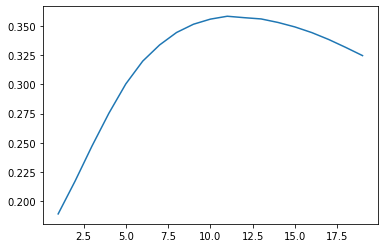

In [6]:
from tqdm.notebook import tqdm

# y-axis is the ratio of buys/not-buys for all data in the 
# x-axis is the ratio denominator

rng=range(1,20)

results2=[]
for i in tqdm(rng):
    _, y, _ = build_Xy(df, window=window, use_atr=True, atr_ratio=(i*2,i), reverse=False)
    results2.append(y.sum() / len(y))
    
plt.plot(rng, results2)

  0%|          | 0/19 [00:00<?, ?it/s]

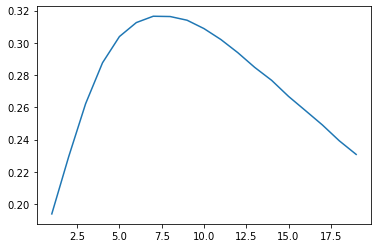

In [7]:
results3=[]
rng = range(1,20)
for i in tqdm(rng):
    _, y, _ = build_Xy(df, window=window, use_atr=True, atr_ratio=(i*3,i), reverse=False)
    results3.append(y.sum() / len(y))
plt.plot(rng, results3)

  0%|          | 0/9 [00:00<?, ?it/s]

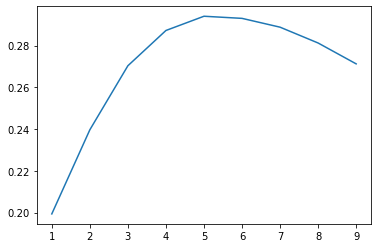

In [8]:
results4=[]
rng = range(1,10)
for i in tqdm(rng):
    _, y, _ = build_Xy(df, window=window, use_atr=True, atr_ratio=(i*4,i), reverse=False)
    results4.append(y.sum() / len(y))
plt.plot(rng, results4)

In [16]:
[0.0025*2**i for i in range(6)]

[0.0025, 0.005, 0.01, 0.02, 0.04, 0.08]

  0%|          | 0/6 [00:00<?, ?it/s]

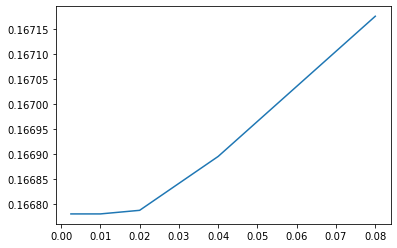

In [17]:
results_p1=[]
rng = [0.0025*2**i for i in range(6)]
for i in tqdm(rng):
    _, y, _ = build_Xy(df, window=window, use_atr=True, atr_ratio=(i,i/2), reverse=False)
    results_p1.append(y.sum() / len(y))
plt.plot(rng, results_p1)

<ipython-input-23-dd825a4f7d69>:1: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.xscale('log', basex=2)


[0.0025, 0.005, 0.01, 0.02, 0.04, 0.08]

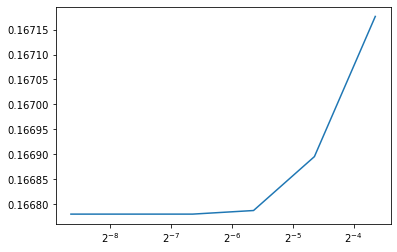

In [23]:
plt.xscale('log', basex=2)
#rng2=[2**i for i in range(6)]
plt.plot(rng, results_p1)
rng

In [12]:
results_p2=[]
rng = [0.0025*i for i in range(1,10)]
for i in tqdm(rng):
    _, y, _ = build_Xy(df, window=window, use_atr=True, atr_ratio=(i,i/3), reverse=False)
    results_p2.append(y.sum() / len(y))
plt.plot(rng, results_p2)

  0%|          | 0/9 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
results_p3=[]
rng = [0.0025*i for i in range(1,10)]
for i in tqdm(rng):
    _, y, _ = build_Xy(df, window=window, use_atr=True, atr_ratio=(i,i/4), reverse=False)
    results_p3.append(y.sum() / len(y))
plt.plot(rng, results_p3)